# Analyzing TV Super Bowl Data

## 1. Introduction:

Whether or not you like football, the Super Bowl is a spectacle. There's a little something for everyone at your Super Bowl party. Drama in the form of blowouts, comebacks, and controversy for the sports fan. There are the ridiculously expensive ads, some hilarious, others gut-wrenching, thought-provoking, and weird. The half-time shows with the biggest musicians in the world, sometimes riding giant mechanical tigers or leaping from the roof of the stadium. It's a show, baby. And in this notebook, we're going to find out how some of the elements of this show interact with each other. After exploring and cleaning our data a little, we're going to answer questions like:

  * What are the most extreme game outcomes?
  * How does the game affect television viewership?
  * How have viewership, TV ratings, and ad cost evolved over time?
  * Who are the most prolific musicians in terms of halftime show performances?
  
  ![left_shark](https://user-images.githubusercontent.com/67468718/103148488-fb8a6080-4714-11eb-80ba-241e183c55e3.jpg)

## 2. Imports:

In [3]:
# Import pandas
import pandas as pd

# Load the CSV data into DataFrames
super_bowls = pd.read_csv('path/datasets/super_bowls.csv')
tv = pd.read_csv('path/datasets/tv.csv')
halftime_musicians = pd.read_csv('path/datasets/halftime_musicians.csv')

# Display the first five rows of each DataFrame
display(super_bowls.head())
display(tv.head())
display(halftime_musicians.head())

,date,super_bowl,venue,city,state,attendance,team_winner,winning_pts,qb_winner_1,qb_winner_2,coach_winner,team_loser,losing_pts,qb_loser_1,qb_loser_2,coach_loser,combined_pts,difference_pts
0,2018-02-04,52,U.S. Bank Stadium,Minneapolis,Minnesota,67612,Philadelphia Eagles,41,Nick Foles,NaN,Doug Pederson,New England Patriots,33,Tom Brady,NaN,Bill Belichick,74,8
1,2017-02-05,51,NRG Stadium,Houston,Texas,70807,New England Patriots,34,Tom Brady,NaN,Bill Belichick,Atlanta Falcons,28,Matt Ryan,NaN,Dan Quinn,62,6
2,2016-02-07,50,Levi's Stadium,Santa Clara,California,71088,Denver Broncos,24,Peyton Manning,NaN,Gary Kubiak,Carolina Panthers,10,Cam Newton,NaN,Ron Rivera,34,14
3,2015-02-01,49,University of Phoenix Stadium,Glendale,Arizona,70288,New England Patriots,28,Tom Brady,NaN,Bill Belichick,Seattle Seahawks,24,Russell Wilson,NaN,Pete Carroll,52,4
4,2014-02-02,48,MetLife Stadium,East Rutherford,New Jersey,82529,Seattle Seahawks,43,Russell Wilson,NaN,Pete Carroll,Denver Broncos,8,Peyton Manning,NaN,John Fox,51,35


,super_bowl,network,avg_us_viewers,total_us_viewers,rating_household,share_household,rating_18_49,share_18_49,ad_cost
0,52,NBC,103390000,NaN,43.1,68,33.4,78.0,5000000
1,51,Fox,111319000,172000000.0,45.3,73,37.1,79.0,5000000
2,50,CBS,111864000,167000000.0,46.6,72,37.7,79.0,5000000
3,49,NBC,114442000,168000000.0,47.5,71,39.1,79.0,4500000
4,48,Fox,112191000,167000000.0,46.7,69,39.3,77.0,4000000


,super_bowl,musician,num_songs
0,52,Justin Timberlake,11.0
1,52,University of Minnesota Marching Band,1.0
2,51,Lady Gaga,7.0
3,50,Coldplay,6.0
4,50,Beyoncé,3.0


## 3. Taking note of dataset issues

For the Super Bowl game data, we can see the dataset appears whole except for missing values in the backup quarterback columns (qb_winner_2 and qb_loser_2), which make sense given most starting QBs in the Super Bowl (qb_winner_1 and qb_loser_1) play the entire game.

From the visual inspection of TV and halftime musicians data, there is only one missing value displayed, but I've got a hunch there are more. The Super Bowl goes all the way back to 1967, and the more granular columns (e.g. the number of songs for halftime musicians) probably weren't tracked reliably over time. Wikipedia is great but not perfect.

An inspection of the .info() output for tv and halftime_musicians shows us that there are multiple columns with null values.

In [5]:
# Summary of the TV data to inspect
tv.info()

print('\n')

# Summary of the halftime musician data to inspect
halftime_musicians.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   super_bowl        53 non-null     int64  
 1   network           53 non-null     object 
 2   avg_us_viewers    53 non-null     int64  
 3   total_us_viewers  15 non-null     float64
 4   rating_household  53 non-null     float64
 5   share_household   53 non-null     int64  
 6   rating_18_49      15 non-null     float64
 7   share_18_49       6 non-null      float64
 8   ad_cost           53 non-null     int64  
dtypes: float64(4), int64(4), object(1)
memory usage: 3.9+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   super_bowl  134 non-null    int64  
 1   musician    134 non-null    object 
 2   num_songs   88 non-null     float64
dtypes: 

## 4. Combined points distribution

For the TV data, the following columns have missing values and a lot of them:

  * total_us_viewers (amount of U.S. viewers who watched at least some part of the broadcast)
  * rating_18_49 (average % of U.S. adults 18-49 who live in a household with a TV that were watching for the entire broadcast)
  * share_18_49 (average % of U.S. adults 18-49 who live in a household with a TV in use that were watching for the entire broadcast)

For the halftime musician data, there are missing numbers of songs performed (num_songs) for about a third of the performances.

There are a lot of potential reasons for these missing values. Was the data ever tracked? Was it lost in history? Is the research effort to make this data whole worth it? Maybe. Watching every Super Bowl halftime show to get song counts would be pretty fun. But we don't have the time to do that kind of stuff now! Let's take note of where the dataset isn't perfect and start uncovering some insights.

Let's start by looking at combined points for each Super Bowl by visualizing the distribution. Let's also pinpoint the Super Bowls with the highest and lowest scores.

In C:\Users\aktha\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\aktha\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\aktha\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\aktha\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\aktha\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

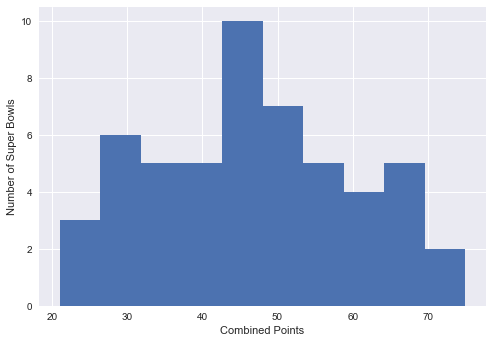

,date,super_bowl,venue,city,state,attendance,team_winner,winning_pts,qb_winner_1,qb_winner_2,coach_winner,team_loser,losing_pts,qb_loser_1,qb_loser_2,coach_loser,combined_pts,difference_pts
0,2018-02-04,52,U.S. Bank Stadium,Minneapolis,Minnesota,67612,Philadelphia Eagles,41,Nick Foles,NaN,Doug Pederson,New England Patriots,33,Tom Brady,NaN,Bill Belichick,74,8
23,1995-01-29,29,Joe Robbie Stadium,Miami Gardens,Florida,74107,San Francisco 49ers,49,Steve Young,NaN,George Seifert,San Diego Chargers,26,Stan Humphreys,NaN,Bobby Ross,75,23


,date,super_bowl,venue,city,state,attendance,team_winner,winning_pts,qb_winner_1,qb_winner_2,coach_winner,team_loser,losing_pts,qb_loser_1,qb_loser_2,coach_loser,combined_pts,difference_pts
43,1975-01-12,9,Tulane Stadium,New Orleans,Louisiana,80997,Pittsburgh Steelers,16,Terry Bradshaw,NaN,Chuck Noll,Minnesota Vikings,6,Fran Tarkenton,NaN,Bud Grant,22,10
45,1973-01-14,7,Memorial Coliseum,Los Angeles,California,90182,Miami Dolphins,14,Bob Griese,NaN,Don Shula,Washington Redskins,7,Bill Kilmer,NaN,George Allen,21,7
49,1969-01-12,3,Orange Bowl,Miami,Florida,75389,New York Jets,16,Joe Namath,NaN,Weeb Ewbank,Baltimore Colts,7,Earl Morrall,Johnny Unitas,Don Shula,23,9


In [6]:
# Import matplotlib and set plotting style
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

# Plot a histogram of combined points
plt.hist(super_bowls['combined_pts'])
plt.xlabel('Combined Points')
plt.ylabel('Number of Super Bowls')
plt.show()

# Display the Super Bowls with the highest and lowest combined scores
display(super_bowls[super_bowls['combined_pts'] > 70])
display(super_bowls[super_bowls['combined_pts'] < 25])

## 5. Point difference distribution
Most combined scores are around 40-50 points, with the extremes being roughly equal distance away in opposite directions. Going up to the highest combined scores at 74 and 75, we find two games featuring dominant quarterback performances. One even happened recently in 2018's Super Bowl LII where Tom Brady's Patriots lost to Nick Foles' underdog Eagles 41-33 for a combined score of 74.

Going down to the lowest combined scores, we have Super Bowl III and VII, which featured tough defenses that dominated. We also have Super Bowl IX in New Orleans in 1975, whose 16-6 score can be attributed to inclement weather. The field was slick from overnight rain, and it was cold at 46 °F (8 °C), making it hard for the Steelers and Vikings to do much offensively. This was the second-coldest Super Bowl ever and the last to be played in inclement weather for over 30 years. The NFL realized people like points, I guess.

UPDATE: In Super Bowl LIII in 2019, the Patriots and Rams broke the record for the lowest-scoring Super Bowl with a combined score of 16 points (13-3 for the Patriots).

Let's take a look at point difference now.

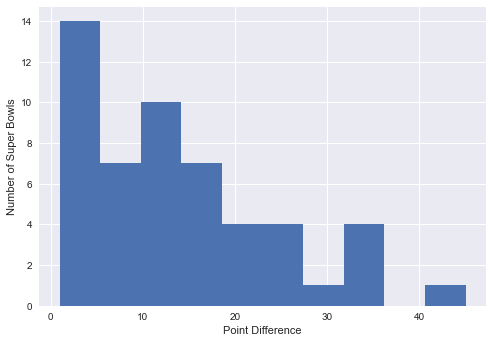

,date,super_bowl,venue,city,state,attendance,team_winner,winning_pts,qb_winner_1,qb_winner_2,coach_winner,team_loser,losing_pts,qb_loser_1,qb_loser_2,coach_loser,combined_pts,difference_pts
27,1991-01-27,25,Tampa Stadium,Tampa,Florida,73813,New York Giants,20,Jeff Hostetler,NaN,Bill Parcells,Buffalo Bills,19,Jim Kelly,NaN,Marv Levy,39,1


,date,super_bowl,venue,city,state,attendance,team_winner,winning_pts,qb_winner_1,qb_winner_2,coach_winner,team_loser,losing_pts,qb_loser_1,qb_loser_2,coach_loser,combined_pts,difference_pts
4,2014-02-02,48,MetLife Stadium,East Rutherford,New Jersey,82529,Seattle Seahawks,43,Russell Wilson,NaN,Pete Carroll,Denver Broncos,8,Peyton Manning,NaN,John Fox,51,35
25,1993-01-31,27,Rose Bowl,Pasadena,California,98374,Dallas Cowboys,52,Troy Aikman,NaN,Jimmy Johnson,Buffalo Bills,17,Jim Kelly,Frank Reich,Marv Levy,69,35
28,1990-01-28,24,Louisiana Superdome,New Orleans,Louisiana,72919,San Francisco 49ers,55,Joe Montana,NaN,George Seifert,Denver Broncos,10,John Elway,NaN,Dan Reeves,65,45
32,1986-01-26,20,Louisiana Superdome,New Orleans,Louisiana,73818,Chicago Bears,46,Jim McMahon,NaN,Mike Ditka,New England Patriots,10,Tony Eason,Steve Grogan,Raymond Berry,56,36


In [7]:
# Plot a histogram of point differences
plt.hist(super_bowls.difference_pts)
plt.xlabel('Point Difference')
plt.ylabel('Number of Super Bowls')
plt.show()

# Display the closest game(s) and biggest blowouts
display(super_bowls[super_bowls['difference_pts'] == 1])
display(super_bowls[super_bowls['difference_pts'] >= 35])

## 6. Do blowouts translate to lost viewers?
The vast majority of Super Bowls are close games. Makes sense. Both teams are likely to be deserving if they've made it this far. The closest game ever was when the Buffalo Bills lost to the New York Giants by 1 point in 1991, which was best remembered for Scott Norwood's last-second missed field goal attempt that went wide right, kicking off four Bills Super Bowl losses in a row. Poor Scott. The biggest point discrepancy ever was 45 points (!) where Hall of Famer Joe Montana's led the San Francisco 49ers to victory in 1990, one year before the closest game ever.

I remember watching the Seahawks crush the Broncos by 35 points (43-8) in 2014, which was a boring experience in my opinion. The game was never really close. I'm pretty sure we changed the channel at the end of the third quarter. Let's combine our game data and TV to see if this is a universal phenomenon. Do large point differences translate to lost viewers? We can plot household share (average percentage of U.S. households with a TV in use that were watching for the entire broadcast) vs. point difference to find out.

<AxesSubplot:xlabel='difference_pts', ylabel='share_household'>

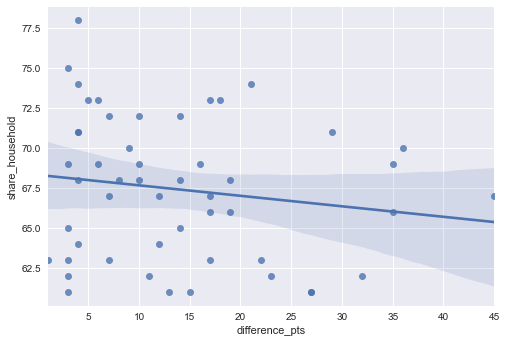

In [8]:
# Join game and TV data, filtering out SB I because it was split over two networks
games_tv = pd.merge(tv[tv['super_bowl'] > 1], super_bowls, on='super_bowl')

# Import seaborn
import seaborn as sns
#games_tv.head()
# Create a scatter plot with a linear regression model fit
sns.regplot(x=games_tv['difference_pts'], y=games_tv['share_household'], data=games_tv)

## 7. Viewership and the ad industry over time
The downward sloping regression line and the 95% confidence interval for that regression suggest that bailing on the game if it is a blowout is common. Though it matches our intuition, we must take it with a grain of salt because the linear relationship in the data is weak due to our small sample size of 52 games.

Regardless of the score though, I bet most people stick it out for the halftime show, which is good news for the TV networks and advertisers. A 30-second spot costs a pretty $5 million now, but has it always been that way? And how have number of viewers and household ratings trended alongside ad cost? We can find out using line plots that share a "Super Bowl" x-axis.

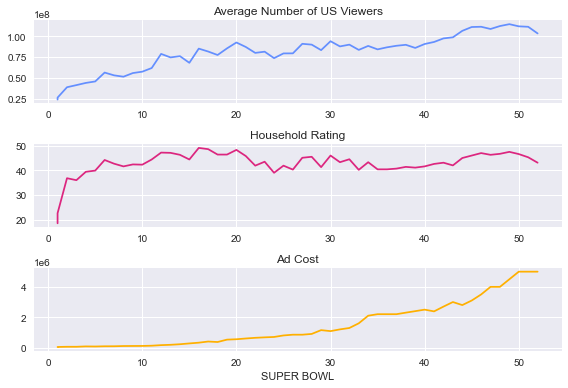

In [9]:
# Create a figure with 3x1 subplot and activate the top subplot
plt.subplot(3, 1, 1)
plt.plot(tv['super_bowl'], tv['avg_us_viewers'], color='#648FFF')
plt.title('Average Number of US Viewers')

# Activate the middle subplot
plt.subplot(3, 1, 2)
plt.plot(tv['super_bowl'], tv['rating_household'], color='#DC267F')
plt.title('Household Rating')

# Activate the bottom subplot
plt.subplot(3, 1, 3)
plt.plot(tv['super_bowl'], tv['ad_cost'], color='#FFB000')
plt.title('Ad Cost')
plt.xlabel('SUPER BOWL')

# Improve the spacing between subplots
plt.tight_layout()

## 8. Halftime shows weren't always this great
We can see viewers increased before ad costs did. Maybe the networks weren't very data savvy and were slow to react? Makes sense since DataCamp didn't exist back then.

Another hypothesis: maybe halftime shows weren't that good in the earlier years? The modern spectacle of the Super Bowl has a lot to do with the cultural prestige of big halftime acts. I went down a YouTube rabbit hole and it turns out the old ones weren't up to today's standards. Some offenders:

  * Super Bowl XXVI in 1992: A Frosty The Snowman rap performed by children.
  * Super Bowl XXIII in 1989: An Elvis impersonator that did magic tricks and didn't even sing one Elvis song.
  * Super Bowl XXI in 1987: Tap dancing ponies. (Okay, that's pretty awesome actually.)
  
It turns out Michael Jackson's Super Bowl XXVII performance, one of the most watched events in American TV history, was when the NFL realized the value of Super Bowl airtime and decided they needed to sign big name acts from then on out. The halftime shows before MJ indeed weren't that impressive, which we can see by filtering our halftime_musician data.

In [10]:
# Display all halftime musicians for Super Bowls up to and including Super Bowl XXVII
halftime_musicians[halftime_musicians['super_bowl'] <= 27].sort_values('super_bowl', ascending=False).dropna()

,super_bowl,musician,num_songs
80,27,Michael Jackson,5.0
81,26,Gloria Estefan,2.0
83,25,New Kids on the Block,2.0
84,24,Pete Fountain,1.0
85,24,Doug Kershaw,1.0
86,24,Irma Thomas,1.0
90,23,Elvis Presto,7.0
91,22,Chubby Checker,2.0
94,21,Grambling State University Tiger Marching Band,8.0
95,21,Spirit of Troy,8.0


## 9. Who has the most halftime show appearances?
Lots of marching bands. American jazz clarinetist Pete Fountain. Miss Texas 1973 playing a violin. Nothing against those performers, they're just simply not Beyoncé. To be fair, no one is.

Let's see all of the musicians that have done more than one halftime show, including their performance counts.

In [13]:
# Count halftime show appearances for each musician and sort them from most to least
halftime_appearances = halftime_musicians.groupby('musician').count()['super_bowl'].reset_index()
halftime_appearances = halftime_appearances.sort_values('super_bowl', ascending=False)

# Display musicians with more than one halftime show appearance
halftime_appearances[halftime_appearances['super_bowl'] > 1].dropna()

,musician,super_bowl
28,Grambling State University Tiger Marching Band,6
104,Up with People,4
1,Al Hirt,4
83,The Human Jukebox,3
76,Spirit of Troy,2
25,Florida A&M University Marching 100 Band,2
26,Gloria Estefan,2
102,University of Minnesota Marching Band,2
10,Bruno Mars,2
64,Pete Fountain,2


## 10. Who performed the most songs in a halftime show?
The world famous Grambling State University Tiger Marching Band takes the crown with six appearances. Beyoncé, Justin Timberlake, Nelly, and Bruno Mars are the only post-Y2K musicians with multiple appearances (two each).

From our previous inspections, the num_songs column has lots of missing values:

A lot of the marching bands don't have num_songs entries.
For non-marching bands, missing data starts occurring at Super Bowl XX.
Let's filter out marching bands by filtering out musicians with the word "Marching" in them and the word "Spirit" (a common naming convention for marching bands is "Spirit of [something]"). Then we'll filter for Super Bowls after Super Bowl XX to address the missing data issue, then let's see who has the most number of songs.

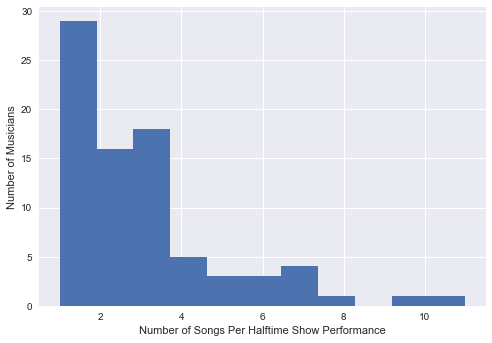

,super_bowl,musician,num_songs
0,52,Justin Timberlake,11.0
70,30,Diana Ross,10.0
10,49,Katy Perry,8.0
2,51,Lady Gaga,7.0
90,23,Elvis Presto,7.0
33,41,Prince,7.0
16,47,Beyoncé,7.0
14,48,Bruno Mars,6.0
3,50,Coldplay,6.0
25,45,The Black Eyed Peas,6.0


In [14]:
# Filter out most marching bands
no_bands = halftime_musicians[~halftime_musicians.musician.str.contains('Marching')]
no_bands = no_bands[~no_bands.musician.str.contains('Spirit')]

# Plot a histogram of number of songs per performance
most_songs = int(max(no_bands['num_songs'].values))
plt.hist(no_bands.num_songs.dropna(), bins=most_songs)
plt.xlabel('Number of Songs Per Halftime Show Performance')
plt.ylabel('Number of Musicians')
plt.show()

# Sort the non-band musicians by number of songs per appearance...
no_bands = no_bands.sort_values('num_songs', ascending=False)
# ...and display the top 15
display(no_bands.head(15))

## 11. Conclusion
So most non-band musicians do 1-3 songs per halftime show. It's important to note that the duration of the halftime show is fixed (roughly 12 minutes) so songs per performance is more a measure of how many hit songs you have. JT went off in 2018, wow. 11 songs! Diana Ross comes in second with 10 in her medley in 1996.

In this notebook, we loaded, cleaned, then explored Super Bowl game, television, and halftime show data. We visualized the distributions of combined points, point differences, and halftime show performances using histograms. We used line plots to see how ad cost increases lagged behind viewership increases. And we discovered that blowouts do appear to lead to a drop in viewers.

This year's Big Game will be here before you know it. Who do you think will win Super Bowl LIII?

In [15]:
# 2018-2019 conference champions
patriots = 'New England Patriots'
rams = 'Los Angeles Rams'

# Who will win Super Bowl LIII?
super_bowl_LIII_winner = patriots
print('The winner of Super Bowl LIII will be the', super_bowl_LIII_winner)

The winner of Super Bowl LIII will be the New England Patriots
